# Correlations between PID methods

This notebook will investigate the relationship between different partial information decomposition methods. We know some of them fail at $k \ge 3$ and that the community doesn't agree with the values provided by $I_{min}$. This suggests that there may be disagreement in these methods beyond these cases. By looking for correlations between them we aim to find out the extent of that disagreement.

In [223]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [224]:
broja = pd.read_csv('broja_df.csv')
ccs = pd.read_csv('ccs_df.csv')
dep = pd.read_csv('dep_df.csv')
imin = pd.read_csv('imin_df.csv')
pm = pd.read_csv('pm_df.csv')

In [225]:
dep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                256 non-null    int64  
 1   rule                      256 non-null    int64  
 2   ((2,),)                   256 non-null    float64
 3   ((1,),)                   256 non-null    float64
 4   ((0,),)                   256 non-null    float64
 5   ((0, 1, 2),)              88 non-null     float64
 6   ((1, 2),)                 88 non-null     float64
 7   ((0, 2),)                 88 non-null     float64
 8   ((0, 2), (1, 2))          88 non-null     float64
 9   ((0, 1),)                 88 non-null     float64
 10  ((0, 1), (1, 2))          88 non-null     float64
 11  ((0, 1), (0, 2))          88 non-null     float64
 12  ((0, 1), (0, 2), (1, 2))  88 non-null     float64
 13  ((2,), (0, 1))            120 non-null    float64
 14  ((1,), (0,

So what we need to do is correlate each of the PI terms for all 5 of the methods. We'll need to turn our 5 dataframes into 18, one for each term.

In [226]:
# set up objects to use in the loop below
df_list = [broja, ccs, dep, imin, pm]
labels = ['broja', 'ccs', 'dep', 'imin', 'pm']
terms = broja.drop(['Unnamed: 0', 'rule'], axis=1).columns
term_dfs = {} 

# collect all five methods' answer for each term
for term in terms:
    term_dict = {}
    for m in range(len(df_list)):
        value = df_list[m][term]
        term_dict[labels[m]] = value

    new_df = pd.DataFrame(term_dict)
    term_dfs[term] = new_df

I'll define a function for my plot so that its easy to iterate on

In [227]:
def correlation_matrix(df):
    # add asterisk to names of columns with nans
    labels = df.columns
    df_marked = df.copy()
    name_map = {}
    for lab in labels:
        if np.sum(pd.isnull(df[lab])) > 0:
            # can missing values be dropped or do we need to penalize
            # the correlation in some way?
            df_marked[lab] = df_marked[lab].dropna()
            name_map.update({lab: lab + '*'})
        
    # calculate the correlations
    df_marked = df.rename(columns=name_map)
    df_corr = df_marked.corr()

    # get the correlations with pandas
    mat = sns.heatmap(df_corr, annot=True, xticklabels=df_marked.columns, yticklabels=df_marked.columns)

    return mat

## Correlations between PI terms of interest

We'll start by looking at the correlations between the PI terms that are easiest to interpret, 3-way synergy, 3-way redundancy, and unique information. This will help us get a sense for how the measures relate to one another and show us how we might trust some methods for certain PI terms but not others.

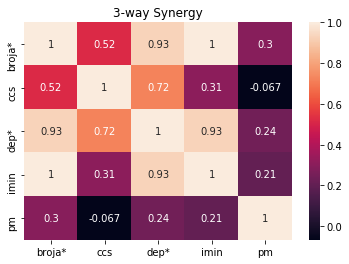

In [228]:
# here's one for synergy
mat = correlation_matrix(term_dfs['((0, 1, 2),)'])
plt.title('3-way Synergy')
plt.show()

### Synergy
There is a range of correlations seen in this figure. $I_{pm}$ is basically uncorrelated with anything else. $I_{BROJA}$, $I_{min}$, and $I_{dep}$ correlate very well with one another and do pretty well with $I_{ccs}$ as well.

$I_{min}$ and $I_{BROJA}$ in particular which were the methods I've spent the most time on and they correlate perfectly on synergy. This is a good sign. Unfortunately we can also see that $I_{BROJA}$ also contains NaNs for the 3-way synergy. If this pattern continues on measures where $I_{BROJA}$ does not have missing values than that would be very good for us.

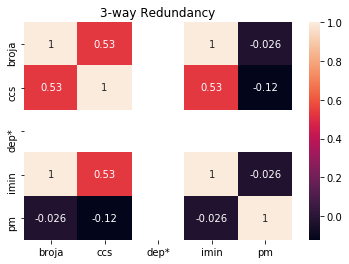

In [229]:
mat = correlation_matrix(term_dfs['((0,), (1,), (2,))'])
plt.title('3-way Redundancy')
plt.show()

### 3-way Redundancy
$I_{dep}$ completely fails here I think there are too many missing values. $I_{ccs}$ correlates pretty well with both $I_{min}$ and $I_{BROJA}$ which again correlate perfectly with one another. This time $I_{BROJA}$ doesn't have any missing values and still correlates perfectly with $T_{min}$

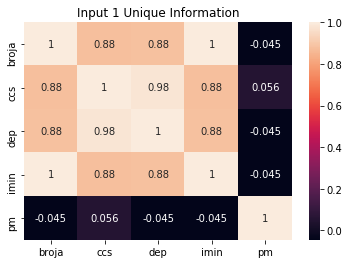

In [230]:
corr = term_dfs['((1,),)'].corr()
mat = correlation_matrix(term_dfs['((1,),)'])
plt.title('Input 1 Unique Information')
plt.show()

### Unique Information
$I_{min}$ and $I_{BROJA}$ Are still perfectly correlated and there are no missing values. We generally have good correlation between measures except for with $I_{pm}$ which seems to be overall uncorrelated with the others.

## Correlations Across Terms

Really we need to know if these patterns hold across all terms. We can do that by looking at both the average of the correlations for each term as well as their distribution.

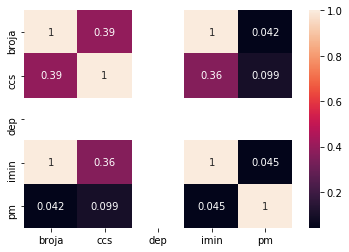

In [231]:
# We also care about avg correlations between these across terms
corr_list = []
for df in term_dfs:
    corr = term_dfs[df].corr()
    corr_list.append(corr.values)

overall_correlations = np.mean(corr_list, axis=0)
sns.heatmap(overall_correlations, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

### Average Correlations
Again, $I_{dep}$ fails too often to correlate with the other measures. Thats okay though because we still see our perfect match between $I_{BROJA}$ and $I_{min}$. In a paper I will probably have to more rogorously account for the missing values to be sure that the values we do have are being correlated with analogous values for $I_{min}$ but I'm convinced for now.

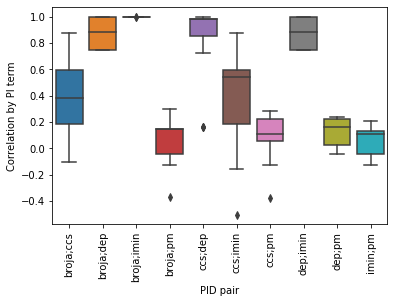

In [232]:
# extract upper (or lower) triangle of correlations
corr_arr = np.array(corr_list)
tri = np.array(np.triu_indices(corr_arr[0].shape[0], k=1))

# get tuples of labels and values
dist_labels = []
dist_vals = []
for ci in range(tri.shape[1]):
    label = '{};{}'.format(labels[tri[0, ci]], labels[tri[1, ci]])
    dist = corr_arr[:, tri[0, ci], tri[1, ci]]
    for d in dist:
        dist_labels.append(label)
        dist_vals.append(d)

# convert them to a dataframe for plotting
dist_dict = {'label': dist_labels, 'val': dist_vals}
dist_df = pd.DataFrame(dist_dict)

sns.boxplot(x='label', y='val', data=dist_df)
plt.xticks(rotation=90)
plt.xlabel('PID pair')
plt.ylabel('Correlation by PI term')
plt.show()

### Distribution of Correlations
This actually looks really promising. According to this, $I_{BROJA}$ is perfectly correlated with $I_{min}$. If this is right than its very good news. $I_{min}$ actually works for $k \ge 3$ where $I_{BROJA}$ and $I_{dep}$ do not. I'm a little skeptical because $I_{BROJA}$ was an early attempt to correct percieved flaws with $I_{min}$.

Interestingly, $I_{pm}$ and $I_{ccs}$ do not correlate. This is weird because they are the two methods based on pointwise information and are fairly different from the rest in terms of their justification.

## $I_{min}$ and $I_{BROJA}$ correlation

In the PID literature $I_{min}$ is criticized for its decomposition of the two bit copy gate. In this gate the output is the concatenation of the two input bits. For the Two Bit Copy $I_{min}$ breaks the two bits into redundancy and synergy when we would expect it to be unique information. 

Maybe the fact that the ECA are limited to 1 bit outputs eliminates this problem because we see perfect agreement with $I_{BROJA}$ and generally good agreement with both $I_{dep}$ and $I_{ccs}$.